### Проведение EDA. Практика

In [ ]:
import os
import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv

# Загрузка переменных окружения
load_dotenv('../.env')

TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "kosmoline_churn_prediction"  # название эксперимента
RUN_NAME = "eda"
ASSETS_DIR = "assets"

# Используйте exist_ok=True чтобы избежать ошибки, если директория уже существует
os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
sns.set_style("white")
sns.set_theme(style="whitegrid")

# Загрузка данных (ваш код остается без изменений)
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)
df.head(2)

DB_DESTINATION_HOST: rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net
DB_DESTINATION_PORT: 6432
DB_DESTINATION_NAME: playground_mle_20250507_39f5f3ff21
DB_DESTINATION_USER: mle_20250507_39f5f3ff21_freetrack


,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,2744,9637-CDTKZ,2014-02-01,NaT,Two year,Yes,Credit card (automatic),114.1,8086.4,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,No,Yes,0
1,2746,3946-JEWRQ,2016-03-01,NaT,One year,Yes,Credit card (automatic),95.2,4563.0,Fiber optic,No,No,No,No,Yes,Yes,Male,0,Yes,No,Yes,0


### Задание 1
Постройте графики количества уникальных пользователей (customer_id), распределённых по таким группам:
1. пользователи по различным type,
2. пользователи по различным payment_method,
3. пользователи по различным internet_service,
4. пользователи по различным gender.
Создайте одну фигуру размером 16.5x12.5 с четырьмя графиками по списку выше. Сохраните вашу картинку в директорию ASSETS_DIR, а файл назовите cat_features_1.

/var/folders/6g/s9qby9js2yd4gy8c0t6tftgh0000gp/T/ipykernel_36772/210341501.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation=45)


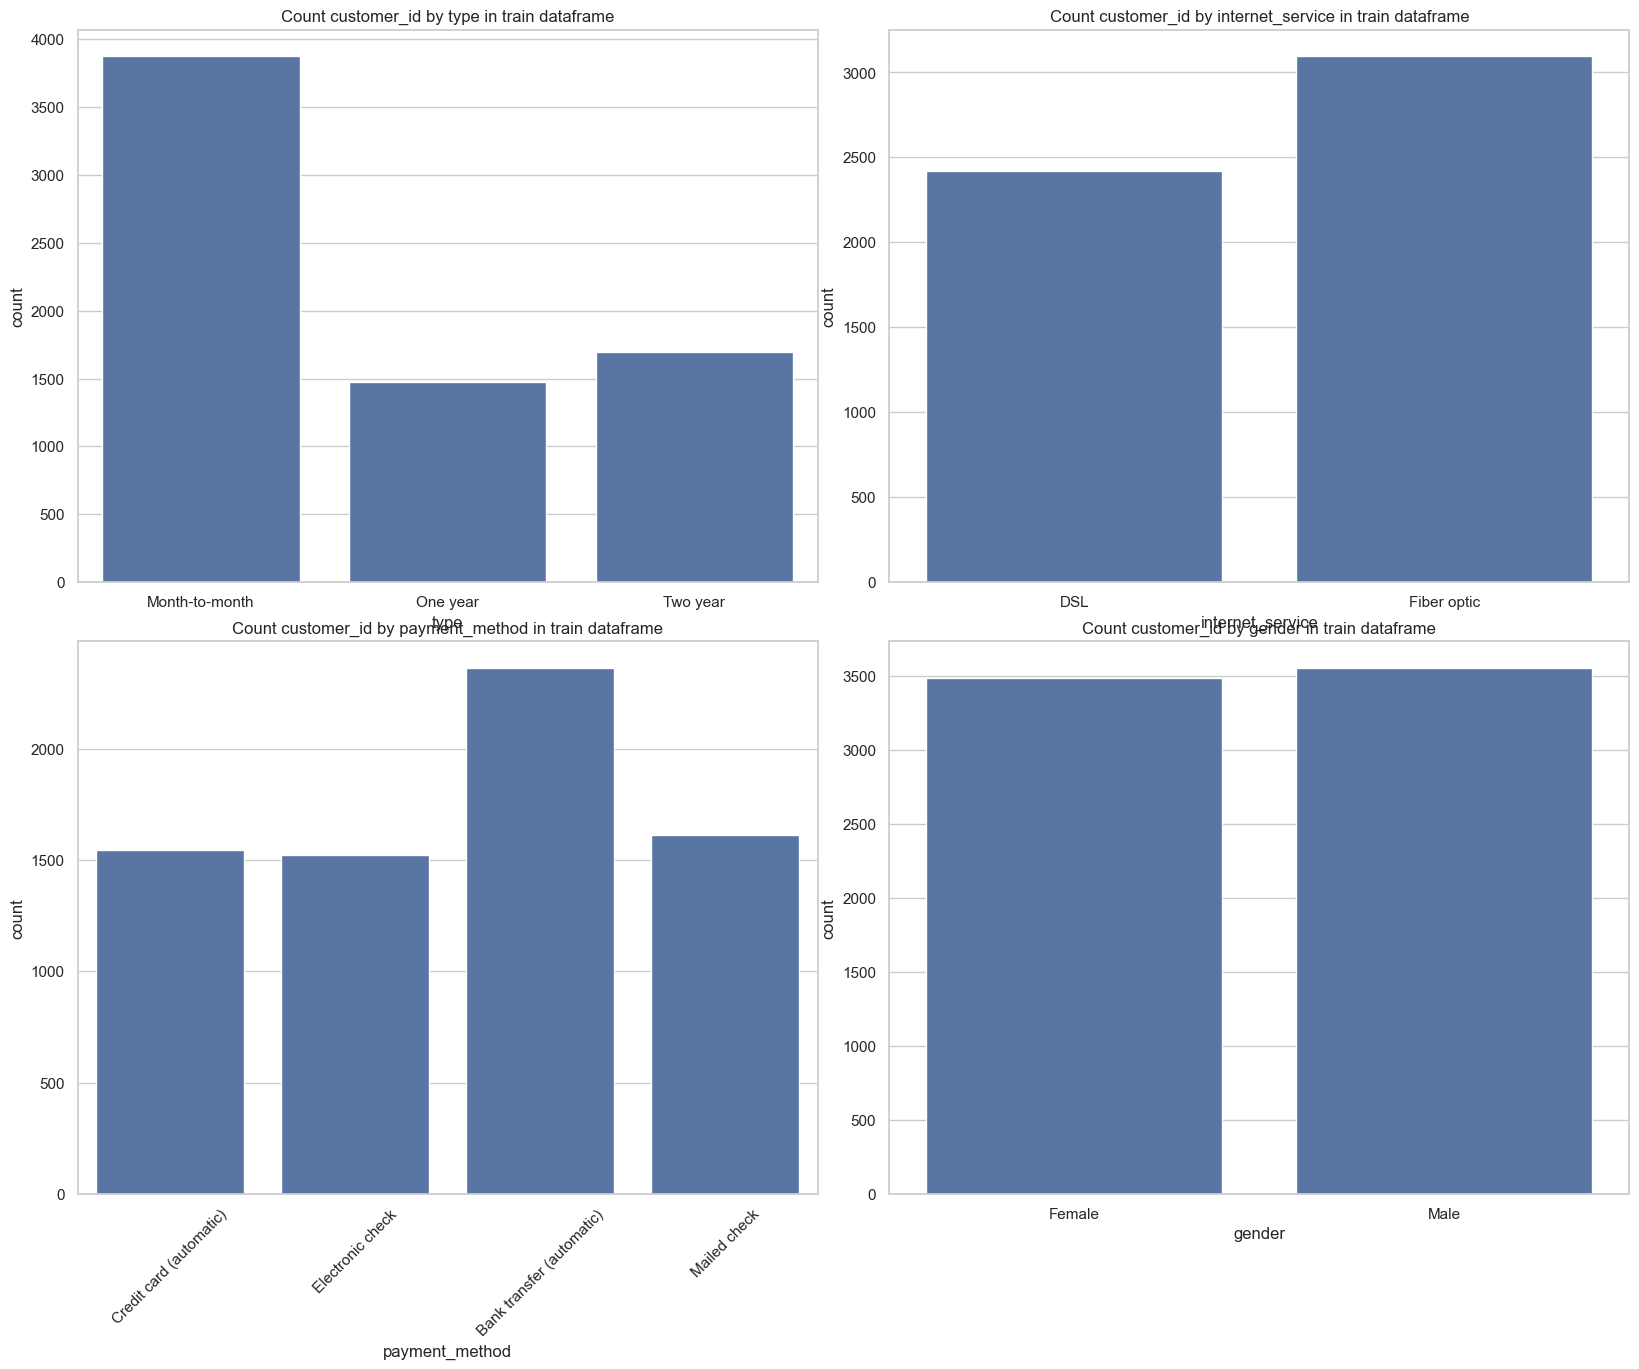

In [2]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)

# График 1: type
x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

# График 2: payment_method
x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation=45)

# График 3: internet_service
x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

# График 4: gender
x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

# Сохранение графика
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))
plt.show()

### Задание 2
Постройте таблицу-воронку для бинарных колонок с подсчётом количества пользователей (count). Отсортируйте их по убыванию и выведите первые 10 строк.

In [3]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]
print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

### Задание 3
Большие таблицы не всегда легко анализировать. Чтобы ускорить этот процесс, можно построить тепловую карту бинарных признаков. Ваша задача — построить её для тех же бинарных признаков. По оси x у вас должны быть значения 0, 1 по оси y — названия признаков. В конце сохраните получившийся график в директорию с артефактами с названием cat_features_2_binary_heatmap.

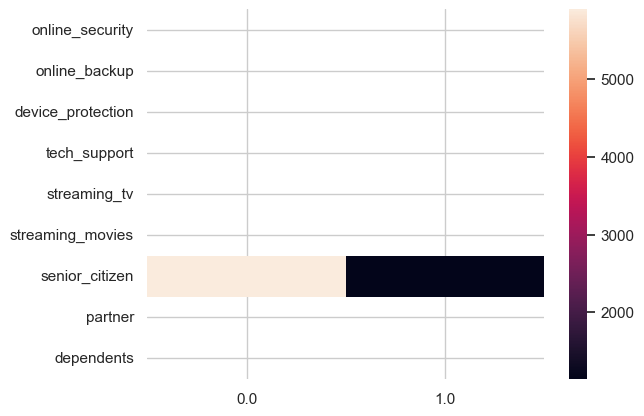

In [5]:
heat_df = df[binary_columns].apply(pd.to_numeric, errors='coerce').apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))
plt.show()


### Задание 4
Постройте два графика для monthly_charges и total_charges, а затем посчитайте средние значение, медиану и моду для каждого begin_date на них. Получившийся график сохраните с названием charges_by_date.

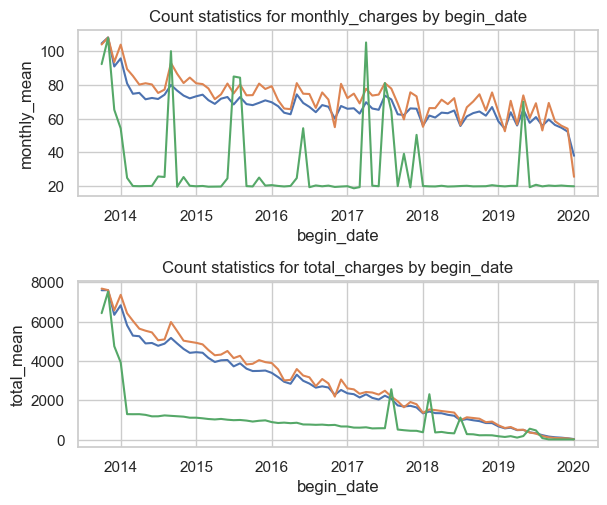

In [8]:
# инициализация переменной для названия колонки
x = "begin_date"
# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]
# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)
# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода
# группировка данных по дате начала и агрегация статистик для ежемесячных платежей
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]
# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]
# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)
# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")
# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")
# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

### Задание 5
Постройте график распределения количества 0 и 1 в вашем датасете. Сохраните график с именем target_count.

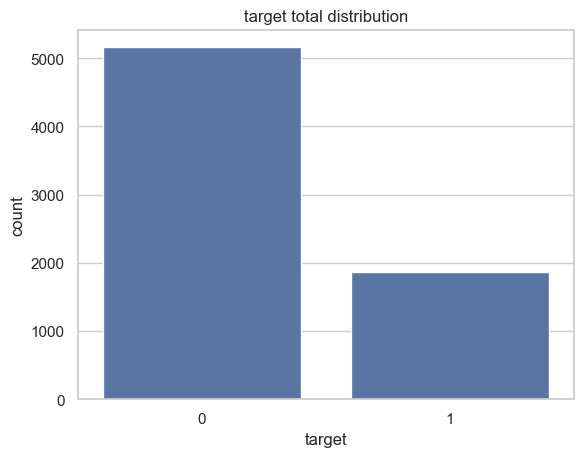

In [18]:
# директория для сохранения картинок
ASSETS_DIR = "assets"
# установка названия колонки для агрегации
x = "target"
# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
target_agg.columns = [x, 'count'] 
# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x=x, y='count')
# установка заголовка графика
plt.title(f"{x} total distribution")
# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

### Задание 6
Постройте четыре графика, отражающих следующие зависимости целевой переменной от признаков:
количество 1 в целевой переменной в зависимости от даты,
количества 1 и 0 в целевой переменной в зависимости от даты,
конверсия (количество1, поделённое на общий размер датасета) в зависимости от даты,
конверсия в зависимости от пола.
График поможет лучше понять природу ваших данных, чтобы учитывать её при обучении модели. Получившуюся картинку сохраните с именем target_by_date.

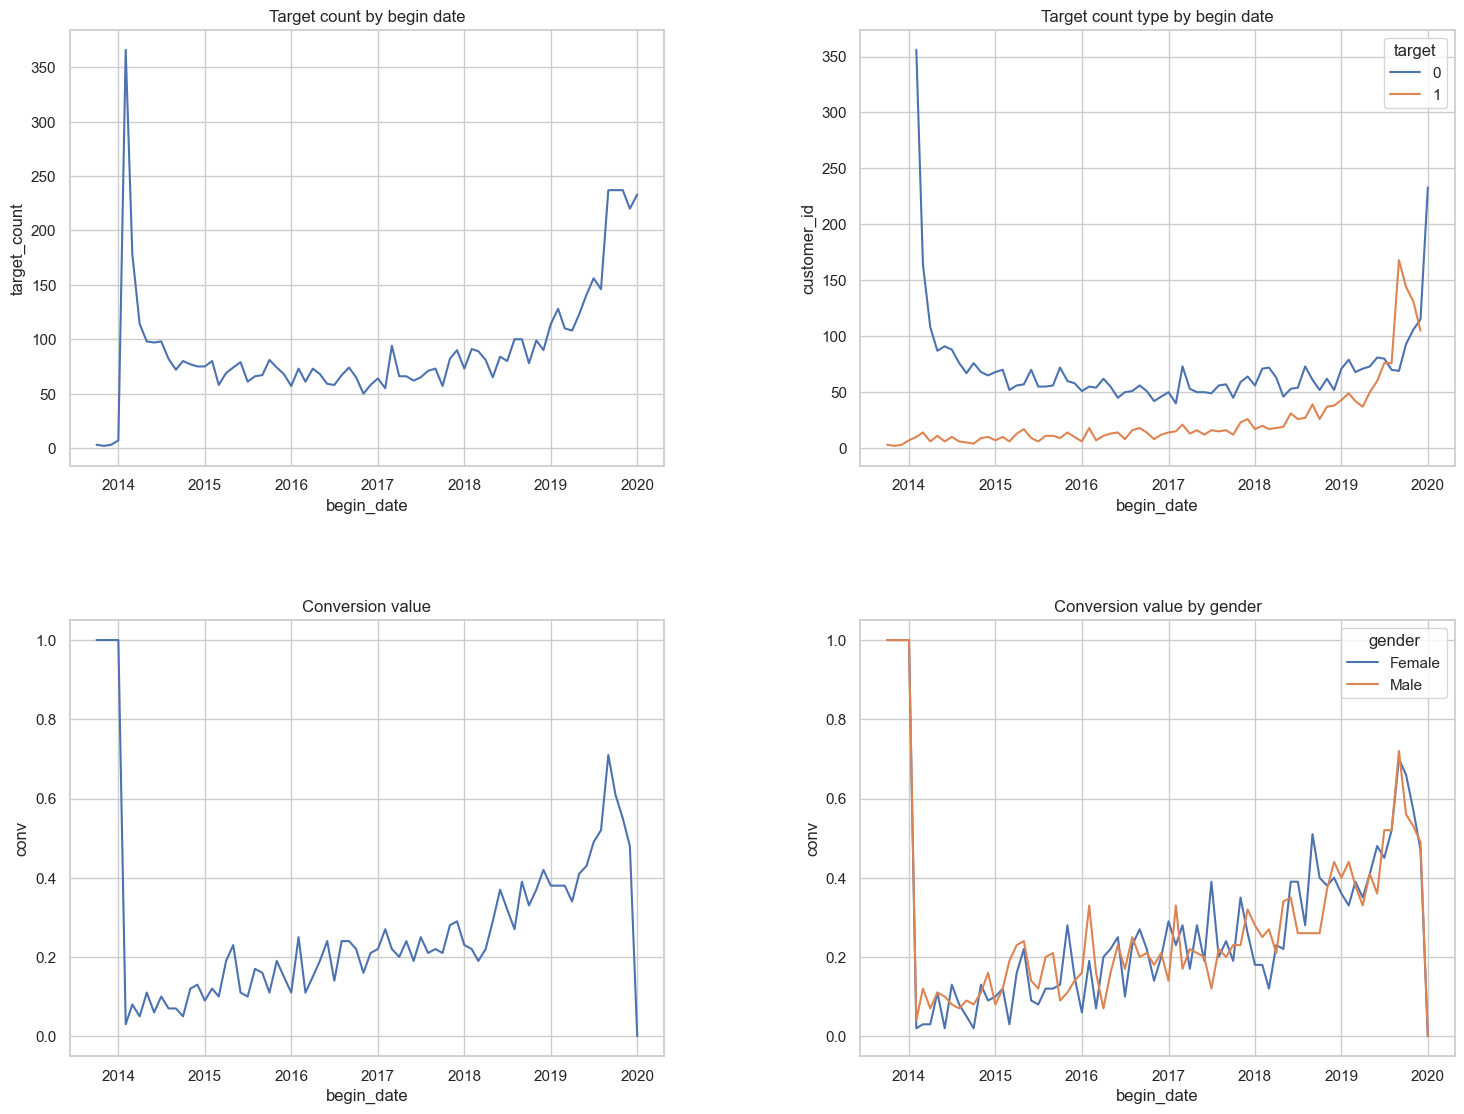

In [19]:
# установка переменных для анализа
x = "begin_date"
target = "target"
# определение статистики для агрегации
stat = ["count"]
# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]
# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()
# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = (conversion_agg['sum'] / conversion_agg['count']).round(2)
# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)
# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры
# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")
# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")
# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")
# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")
# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

### Задание 7
Постройте графики распределения monthly_charges и total_charges для каждого события. График отобразите с оценкой плотности, а затем сохраните с названием chargest_by_target_dist.

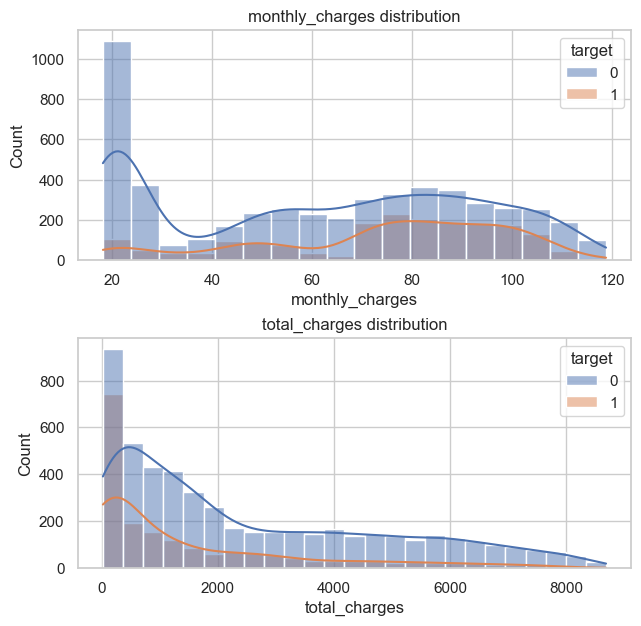

In [20]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"
# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры
# визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(
    data=df,  # датафрейм с данными
    x=charges[0],  # первый вид платежей для визуализации
    hue=target,  # разделение данных по целевой переменной
    kde=True,  # включение оценки плотности распределения (Kernel Density Estimate)
    ax=axs[0]  # указание, на каком подграфике отобразить гистограмму
)
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы
# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(
    data=df,  # датафрейм с данными
    x=charges[1],  # второй вид платежей для визуализации
    hue=target,  # разделение данных по целевой переменной
    kde=True,  # включение оценки плотности распределения
    ax=axs[1]  # указание, на каком подграфике отобразить вторую гистограмму
)
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы
# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

При анализе важно ничего не потерять, особенно получившиеся на выходе артефакты. Сохраните их в директорию ASSETS_DIR при помощи MLflow. Сделать это можно следующим образом:

In [21]:
from dotenv import load_dotenv
load_dotenv('../.env')

# определяем основные credentials
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("S3_ACCESS_KEY")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("S3_SECRET_KEY")

# Подключение к MLflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# Проверяем, существует ли эксперимент, если нет - создаём
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    print(f"Создан новый эксперимент с ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Используется существующий эксперимент с ID: {experiment_id}")

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")
    
    # Логируем все артефакты из директории
    mlflow.log_artifacts(ASSETS_DIR)
    print(f"Артефакты из {ASSETS_DIR} успешно загружены в MLflow")

Используется существующий эксперимент с ID: 4
Run ID: 4caf81811aa84c7995e83911eaded728
Артефакты из assets успешно загружены в MLflow
🏃 View run eda at: http://127.0.0.1:5001/#/experiments/4/runs/4caf81811aa84c7995e83911eaded728
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/4


In [22]:
# Получаем последний run из эксперимента
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=["start_time DESC"], max_results=1)

if not runs.empty:
    run_id = runs.iloc[0]['run_id']
    print(f"Последний Run ID: {run_id}")
else:
    print("Не найдено ни одного run в эксперименте")

Последний Run ID: 4caf81811aa84c7995e83911eaded728


In [23]:
import os
print("Файлы в директории ASSETS_DIR:")
for file in os.listdir(ASSETS_DIR):
    print(f"  - {file}")

Файлы в директории ASSETS_DIR:
  - target_count.png
  - charges_by_date.png
  - cat_features_2_binary_heatmap.png
  - cat_features_1.png
  - target_by_date.png
  - chargest_by_target_dist.png
